# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import pprint
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 3000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/var/folders/tf/f9bv6m516pjcr2ytmmh92cw00000gn/T/ipykernel_28573/3674931809.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

/var/folders/tf/f9bv6m516pjcr2ytmmh92cw00000gn/T/ipykernel_28573/3398560250.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score                      0.9868
SAT Math Avg. Score                                  0.9726
SAT Writing Avg. Score                               0.9878
sat_score                                            1.0000
AP Test Takers                                       0.5231
Total Exams Taken                                    0.5143
Number of Exams with scores 3 4 or 5                 0.4632
Total Cohort                                         0.3251
CSD                                                  0.0429
NUMBER OF STUDENTS / SEATS FILLED                    0.3946
NUMBER OF SECTIONS                                   0.3627
AVERAGE CLASS SIZE                                   0.3810
SIZE OF SMALLEST CLASS                               0.2499
SIZE OF LARGEST CLASS                                0.3144
SCHOOLWIDE PUPIL-TEACHER RATIO                          NaN
schoolyear                                              NaN
fl_percent                              

## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
# survey_fields.remove("DBN")

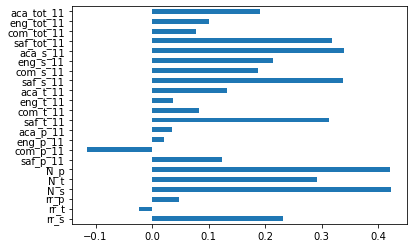

In [11]:
# import plotting library
import matplotlib.pyplot as plt

# Make bar plot for correlations between survey_fields and sat_score
correlations.loc["rr_s":"aca_tot_11"].plot.barh()
plt.show()

### Observations
It looks like the strongest correlations are between the SAT scores and the number of parents or students that respond to the survey. The response rate, on the other hand, is not correlated. This discrepancy might be worth looking at.
<br>
<br>
Additional correlations are between SAT scores and two other factors, the students academic expectations and the perception of safety and respect by students, teachers, and parents. The next two sections look at each.
## SAT Scores & Safety Scores

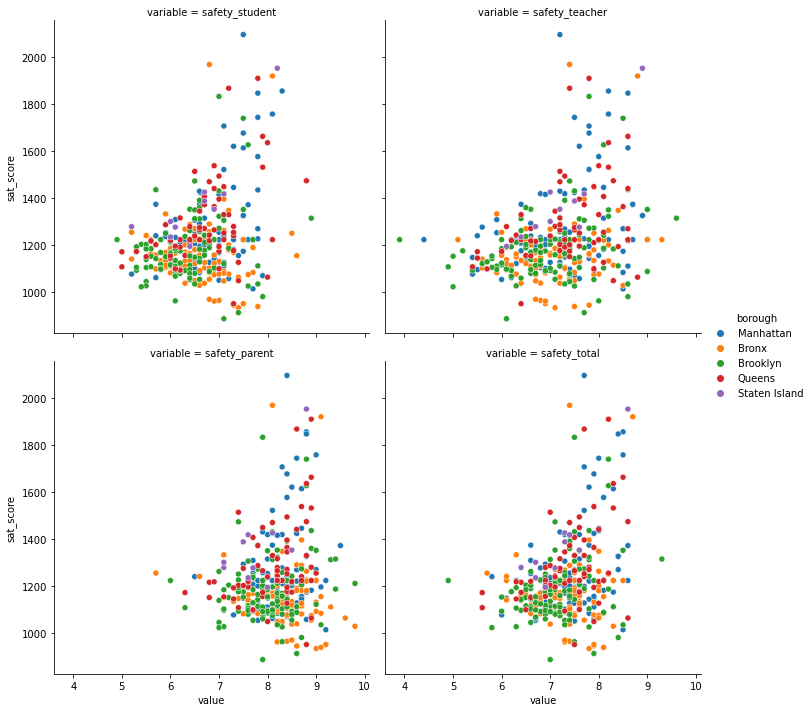

In [12]:
# create melted df from combined preserving school borough & DBN, safety scores, and SAT scores
boroughs_long = combined[["boro", "DBN", "sat_score", "saf_s_11", "saf_t_11", "saf_p_11", "saf_tot_11"]]
boroughs_columns = ["borough", "DBN", "sat_score", "safety_student", "safety_teacher", "safety_parent", "safety_total"]
boroughs_long.columns = boroughs_columns
boroughs_long = boroughs_long.melt(id_vars=["borough", "DBN", "sat_score"])

# scatter plot with borough, SAT scores, and safety scores (0-10)
# plots are for student, teacher, parent, and total safety scores
import seaborn as sns
sns.relplot(data=boroughs_long, x="value", y="sat_score", hue="borough", col="variable", col_wrap=2)
plt.show()

In [13]:
boroughs_means = combined.groupby("boro").mean()
boroughs_means = boroughs_means[["sat_score", "saf_s_11", "saf_t_11", "saf_p_11", "saf_tot_11"]]
boroughs_means.reset_index(inplace=True)
boroughs_columns = ["borough", "sat_score", "safety_student", "safety_teacher", "safety_parent", "safety_total"]
boroughs_means.columns = boroughs_columns
print(boroughs_means)

     borough           sat_score         safety_student       safety_teacher        safety_parent        safety_total    
0          Bronx           1,157.5982               6.6066               7.0269               8.3462               7.3226
1       Brooklyn           1,181.3645               6.3708               6.9858               8.0368               7.1292
2      Manhattan           1,278.3314               6.8314               7.2878               8.2889               7.4733
3         Queens           1,286.7530               6.7219               7.3656               8.0984               7.3875
4  Staten Island           1,382.5000               6.5300               7.2100               7.8000               7.2000


 ### Observations
The scatter plots show two areas influencing the correlation between SAT scores and perceptions of safety and respect. First, the highest SAT scores come from schools with above average perceptions of safety and respect. Second, it looks like most schools have both SAT and safety and respect scores below the median values. It is also interesting that parents have a noticeably higher perception of safety and respect than either teachers or students.
<br>
<br>
Grouping schools by borough and averaging scores paints a different picture. This seems to indicate that SAT scores and perception of safety do not have a strong positive correlation at all. For instance, Staten Island has the highest average SAT scores and Bronx the lowest. However, the student and parent perception of safety and respect scores are higher in the Bronx than in Staten Island. And while Manhattan has mostly the highest safety and respect scores, it ranks in the middle for SAT scores/
 ## SAT Scores & Student Academic Expectations

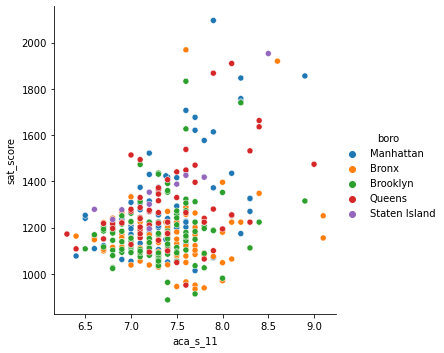

In [14]:
# scatter plot with borough, SAT scores, and academic expectations (0-10)
sns.relplot(data=combined, x="aca_s_11", y="sat_score", hue="boro")
plt.show()

### Observations
The academic expectation scatter plot shows similar results to those for perception of safety and respect. Again, there are very few schools in the upper half of the academic expectation scores, and among them about half have better than average SAT scores. Also, we see that most schools have both SAT scores and academic expectations that are below the median value.

## SAT Scores & Demographics on Race/Ethnicity
Taking an objective look at the relationship between race & ethnicity and SAT scores in NYC schools can help in creating an egalitarian public school system that delivers success to all students.

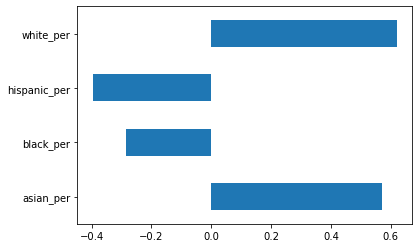

In [15]:
# Make bar plot for correlations between survey_fields and sat_score
correlations.loc[["asian_per", "black_per", "hispanic_per", "white_per"]].plot.barh()
plt.show()

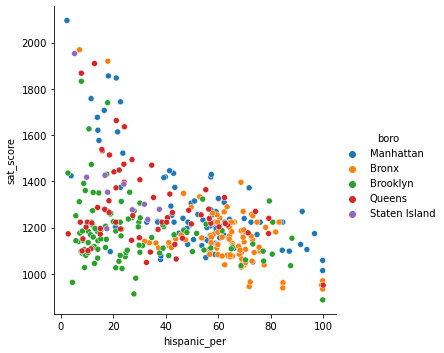

In [16]:
# Scatter plot for SAT scores and percent hispanic
sns.relplot(data=combined, x="hispanic_per", y="sat_score", hue="boro")
plt.show()

### Observations
The bar chart for race & ethnicity paints a stark picture, showing a strong negative correlation between SAT scores and the percentage of Hispanic or Black students in the school. That being said, the scatter plot suggests something a little more nuanced.
<br>
<br>
While the highest SAT scores do occur in schools with a low percentage of Hispanic students, this is only about 6% of the schools in the data set. There are also about 5-10 schools that show 100% Hispanic students. These schools do have some of the lowest SAT scores. But more than 90% of the schools show an even distribution of SAT scores below 1400 with the percentage of Hispanic students ranging from 0-99%.
<br>
<br>
Additionally, almost all the schools in the Bronx have more than half the student population identifying as Hispanic. There are just a few with less than 40% Hispanic, and two of these schools score the highest SAT averages. 
<br>
<br>
That creates three groups of schools, with one group being divided again in two. The following sections take a look at each.
## Groups

In [23]:
# create three groups: high_sat, all_hispanic, majority

SAT_schools = combined["Name"][combined["sat_score"] > 1600]
SAT_schools_Bronx = combined["Name"][(combined["sat_score"] > 1600) & (combined["boro"]=="Bronx")]

4      NEW EXPLORATIONS INTO SCIENCE TECH AND MATH     
5      BARD HIGH SCHOOL EARLY COLLEGE                  
24     NYC LAB SCHOOL FOR COLLABORATIVE STUDIES        
26     ELEANOR ROOSEVELT HIGH SCHOOL                   
27     MILLENNIUM HIGH SCHOOL                          
37     STUYVESANT HIGH SCHOOL                          
60     BEACON HIGH SCHOOL                              
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART
79     HIGH SCHOOL FOR MATHEMATICS SCI AND ENGINEERING 
151    BRONX HIGH SCHOOL OF SCIENCE                    
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEG
187    BROOKLYN TECHNICAL HIGH SCHOOL                  
198    BROOKLYN LATIN                                  
278    LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES  
287    BARD HIGH SCHOOL EARLY COLLEGE II               
302    TOWNSEND HARRIS HIGH SCHOOL                     
327    QUEENS HIGH SCHOOL FOR SCIENCES AT YORK COLLEGE 
346    BACCALAUREATE SCHOOL FOR GLOBAL EDUCATION

151    BRONX HIGH SCHOOL OF SCIENCE                    
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEG
Name: Name, dtype: object

In [ ]:
display(SAT_schools)
display(SAT_schools_Bronx)